# Categorization of neurons
In this notebook we are going to categorize components by their place.
$\newcommand{set}[1]{\{ #1 \}}$
$\newcommand{DS}{\displaystyle}$
$\newcommand{brac}[1]{\left( #1 \right)}$
$\newcommand{mbb}[1]{\mathbb{#1}}$
$\newcommand{mbf}[1]{\mathbf{#1}}$
$\newcommand{mc}[1]{\mathcal{#1}}$
$\newcommand{newline}{ \\\DS}$
$\newcommand{mean}[1]{\bar{#1}}$
$\newcommand{mbf}[1]{\mathbf{#1}}$
$\newcommand{P}{\mbf{P}}$
$\newcommand{E}{\mbf{E}}$
$\newcommand{eps}{\epsilon}$

In [1]:
# Imports
import os
import glob
import scipy.stats as stats
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from math import *

In [2]:
# Load data
atRoot = 'atRoot' in vars()
if not atRoot:
    os.chdir("..")
atRoot = True
files = glob.glob("output/*.txt")

In [3]:
class Point:
    def __init__(self, p: tuple, n: int, owner):
        self.point = p
        self.owner = owner
        self.n = n
components = dict()
for fname in tqdm(files):
    owner = fname.split("/")[-1].split(".")[0]
    with open(fname,"r") as f:
        components[owner] = []
        component = []
        for line in f.readlines():
            line = line.strip()
            #if line == 'COMPONENT:' and len(component) > 0:
            #    components[owner].append(component)
                # component = [] # <--- UNCOMMENT THIS LINE TO DISTINGUISH COMPONENTS
            #    continue
            if line == 'COMPONENT:':
                continue
            x, y = line.split(',')
            x = float(x)
            y = float(y)
            component.append(Point((x,y),owner, 1))
        if len(component) > 1:
            components[owner].append(component)

100%|██████████| 554/554 [00:04<00:00, 134.09it/s]


In order to simplify catregorization we may find means by each of components and then categorize those means.

In [4]:
padd = lambda p1, p2: tuple([p1[i]+p2[i] for i in range(max(p1.__len__(),p2.__len__()))])
pdiv = lambda p, d: tuple([x/d for x in p])
avg = lambda a: sum(a)/len(a)
def component_mean(component: list):
    mean = (0.0,0.0)
    for p in component:
        assert isinstance(p, Point)
        mean = padd(p.point,mean)
    return pdiv(mean,len(component))

In [5]:
points = []
component2point = dict()
for key in tqdm(components.keys()):
    data = components[key]
    i = 0
    for component in data:
        i += 1
        assert isinstance(key,str)
        p = Point(component_mean(component), len(data), key)
        points.append(p)
        component2point[key] = p

100%|██████████| 554/554 [00:01<00:00, 437.91it/s]


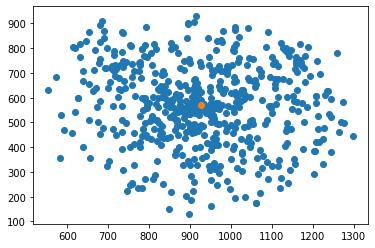

In [6]:
X, Y = [], []
for point in points:
    x, y = point.point
    X.append(x)
    Y.append(y)
plt.scatter(X, Y)
plt.scatter([avg(X)],[avg(Y)]) # Global mean
plt.show()

## Naive $\epsilon$ method

<p>The naive $\epsilon$ method of categorizing by means suggests to find all points that are having distance of $\epsilon$ from category.</p>
Let distance metric $\rho$ between two components be:
$$
\displaystyle 
\rho(a, b)=\sqrt{
    (\mean{a_x}-\mean{b_x})^2+
    (\mean{a_y}-\mean{b_y})^2
}
$$

where $\mean{a},\mean{b}$ are means by first and second components respectively. 

In order to perform this method we should select $k$ components where $k$ is number of classes, by one component from each class. Then for each choosen compenent $c_x$ component we find other components $c_1,...,c_i,...,c_y$, s.t. $\rho(c_x,c_i)\le \eps$

In [7]:
def plot_component(data):
    X=[]
    Y=[]
    for point in data:
        x,y=point.point
        X.append(x)
        Y.append(y)
    plt.scatter(np.array(X),np.array(Y))
EPS = 50.0
# COMPONENTS=[components["342"][0], components["357"][0], components["122"][0], components["127"][0], components["38"][0]]
COMPONENTS=["342", "357", "122", "127", "38"]

In [8]:
rho = lambda p1, p2: sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
def find_nearest(_id: str):
    neighbours = []
    p  = component2point[_id]
    for point in points:
        if rho(point.point, p.point) < EPS:
            neighbours.append(point)
    return neighbours

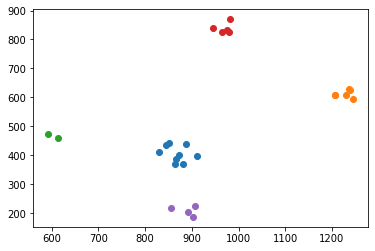

In [9]:
classes = []
for _id in COMPONENTS:
    classes.append(find_nearest(_id))
for cls in classes:
    plot_component(cls)
plt.show()

As we can see this method is too naive and does not classify all components. But it can be useful for collecting initial dataset for other algorithms.

## $k$-means algorithm 
Another approach is to use $k$-means algorithm. Below the completely unsupervised version is shown, so by default `k-means++` algorithm is used to find centroids. 

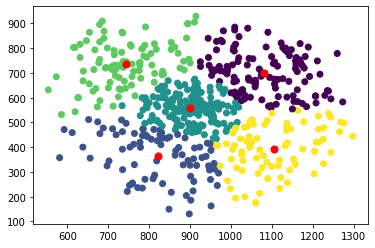

In [10]:
from pandas import DataFrame
from sklearn.cluster import KMeans
data = DataFrame({"x": X,"y": Y},columns = ["x", "y"])
kmeans = KMeans(n_clusters = 5).fit(data)
centroids = kmeans.cluster_centers_
plt.scatter(data['x'], data['y'], c= kmeans.labels_.astype(float))
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()

But it would be more useful to pass existing centroids:

/Library/Python/3.8/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


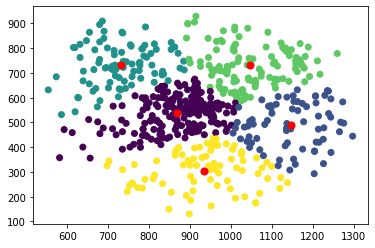

In [11]:
centroids = [list(component2point[key].point) for key in COMPONENTS]
kmeans = KMeans(init = np.array(centroids), n_clusters = 5).fit(data)
centroids = kmeans.cluster_centers_
plt.scatter(data['x'], data['y'], c= kmeans.labels_.astype(float))
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
plt.show()